# Fault Algebras

The main question being asked is, how to combine and negate fault patterns.

In [1]:
from enum import Enum
import copy

## Fault Patterns

### Predicate

First, we define a way to capture the status of an input. There can be four outcomes when an input is executed:

* Success (failure condition reproduced)
* Failed (failure condition not reproduced)
* Invalid (Did not reach failure condition -- possibly semantically invalid)
* Timeout (equivalant to Failed)

In [2]:
class PRes(str, Enum):
    success = 'SUCCESS'
    failed = 'FAILED'
    invalid = 'INVALID'
    timeout = 'TIMEOUT'

Next, we define our predicate. It is a simple test for doubled parenthesis such as `((..))` or an expression `0 / 0`

In [3]:
import re

In [4]:
def expr_double_paren(inp):
    if re.match(r'.*[(][(].*[)][)].*', inp):
        return PRes.success
    #if re.match(r'.*0 / 0.*', inp):
    #    return PRes.success
    return PRes.failed

In [5]:
my_predicate = expr_double_paren

We also define an input.

In [6]:
expr_input =  '1 + ((2 * 3 / 4))'

In [7]:
my_input = expr_input

We verify that we can reproduce the failing condition correctly.

In [8]:
assert my_predicate(my_input) == PRes.success

In [9]:
assert my_predicate('(1 + 2)') == PRes.failed

In [10]:
assert my_predicate('0 / 0') == PRes.failed

### Grammar

A context-free grammar is represented as a Python dict, with each nonterminal symbol forming a key, and each nonterminal _defined_ by a list of expansion rules. For example, the expression grammar for parsing arithmetic expressions is given below.

In [11]:
EXPR_GRAMMAR = {'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']]}

In [12]:
EXPR_G = {'[start]': '<start>', '[grammar]': EXPR_GRAMMAR}

Note the convetion we used: Each nonterminal is enclosed in angle brackets. E.g. `<expr>`. We now define a function that can distinguish terminal symbols from nonterminals.

The `is_nt()` function checks if the given node is a terminal or not.

In [13]:
def is_nt(symbol):
     return symbol and (symbol[0], symbol[-1]) == ('<', '>')

#### The parser

Given the grammar, and an input, we can parse it into a derivation tree.
The `Parser` below is from [fuzzingbook.org](https://www.fuzzingbook.org/html/Parser.html), and provides a generic context-free parser. This is present in the `src` directory.

In [14]:
from Parser import EarleyParser as Parser

How do we check that our parse succeeded? We can convert the derivation tree back to the original string and check for equality.

The `tree_to_str()` function converts a derivation tree to its original string.

In [15]:
def tree_to_str(node):
    name, children, *rest = node
    if not children:
        return name
    return ''.join([tree_to_str(c) for c in children])

In [16]:
Ts = tree_to_str

In [17]:
expr_parser = Parser(EXPR_GRAMMAR, start_symbol='<start>', canonical=True)
parsed_expr = list(expr_parser.parse(my_input))[0]
tree_to_str(parsed_expr)

'1 + ((2 * 3 / 4))'

#### Display

While converting to strings are easy, it is unsatisfying. We want to make our output look pretty, and inspect the tree structure of the parsed tree. So we define graphical tree display (code from fuzzingbook)

In [18]:
from graphviz import Digraph

In [19]:
from IPython.display import display, Image

In [20]:
def zoom(v, zoom=True):
    # return v directly if you do not want to zoom out.
    if zoom:
        return Image(v.render(format='png'))
    return v

In [21]:
class DisplayTree():
    def __init__(self):
        pass

    def extract_node(self, node, id):
        symbol, children, *annotation = node
        return symbol, children, ''.join(str(a) for a in annotation)
    
    def node_attr(self, dot, nid, symbol, ann):
        dot.node(repr(nid), symbol + ' ')
        
    def edge_attr(self, dot, start_node, stop_node):
        dot.edge(repr(start_node), repr(stop_node))
        
    def graph_attr(self, dot):
        dot.attr('node', shape='plain')
        
    def display(self, derivation_tree):
        counter = 0
        def traverse_tree(dot, tree, id=0):
            (symbol, children, annotation) = self.extract_node(tree, id)
            self.node_attr(dot, id, symbol, annotation)
            if children:
                for child in children:
                    nonlocal counter
                    counter += 1
                    child_id = counter
                    self.edge_attr(dot, id, child_id)
                    traverse_tree(dot, child, child_id)
        dot = Digraph(comment="Derivation Tree")
        self.graph_attr(dot)
        traverse_tree(dot, derivation_tree)
        return dot
    
    def __call__(self, dt):
        return self.display(dt)

In [22]:
display_tree = DisplayTree()

In [23]:
# procedural
def extract_node_(node, id):
    symbol, children, *annotation = node
    return symbol, children, ''.join(str(a) for a in annotation)
def node_attr_(dot, nid, symbol, ann): dot.node(repr(nid), symbol + ' ')
def edge_attr_(dot, start_node, stop_node): dot.edge(repr(start_node), repr(stop_node))
def graph_attr_(dot): dot.attr('node', shape='plain')
def display_tree_(derivation_tree):
    counter = 0
    def traverse_tree(dot, tree, id=0):
        (symbol, children, annotation) = extract_node(tree, id)
        node_attr(dot, id, symbol, annotation)
        if children:
            for child in children:
                nonlocal counter
                counter += 1
                child_id = counter
                edge_attr(dot, id, child_id)
                traverse_tree(dot, child, child_id)
    dot = Digraph(comment="Derivation Tree")
    graph_attr(dot)
    traverse_tree(dot, derivation_tree)
    return dot

We are now ready to display the tree structure.

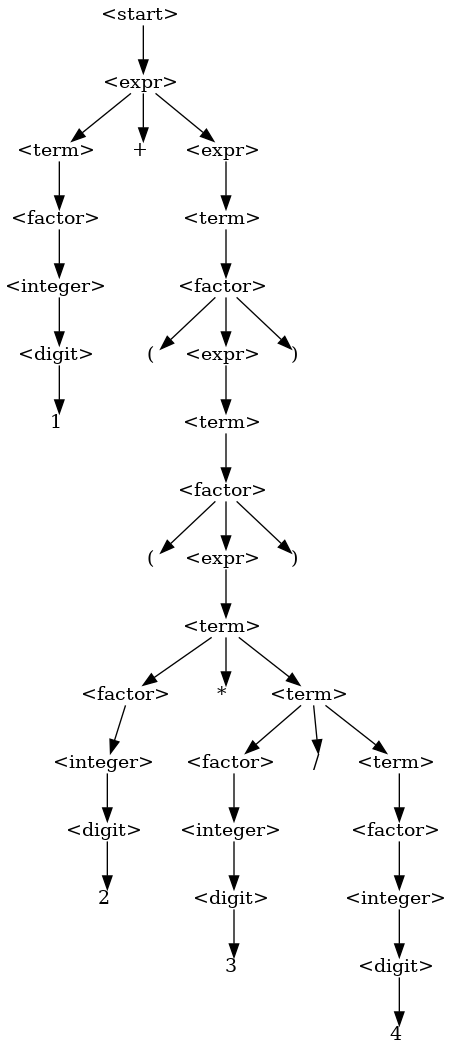

In [24]:
zoom(display_tree(parsed_expr))

#### A Fuzzer

In order to define abstraction, we need to be able to generate values based on a grammar. Our fuzzer is able to do that.

In [25]:
import random

##### The interface

In [26]:
class Fuzzer:
    def __init__(self, grammar):
        self.grammar = grammar

    def fuzz(self, key='<start>', max_num=None, max_depth=None):
        raise NotImplemented()

##### The implementation

The fuzzer tries to randomly choose an expansion when more than one expansion is available. If however, it goes beyond max_depth, then it chooses the cheapest nodes. The cheapest nodes are those nodes with minimum further expansion (no recursion).

In [27]:
class LimitFuzzer(Fuzzer):
    def symbol_cost(self, grammar, symbol, seen):
        if symbol in self.key_cost: return self.key_cost[symbol]
        if symbol in seen:
            self.key_cost[symbol] = float('inf')
            return float('inf')
        v = min((self.expansion_cost(grammar, rule, seen | {symbol})
                    for rule in grammar.get(symbol, [])), default=0)
        self.key_cost[symbol] = v
        return v

    def expansion_cost(self, grammar, tokens, seen):
        return max((self.symbol_cost(grammar, token, seen)
                    for token in tokens if token in grammar), default=0) + 1

    def gen_key(self, key, depth, max_depth):
        if key not in self.grammar: return key
        if depth > max_depth:
            assert key in self.cost
            clst = sorted([(self.cost[key][str(rule)], rule) for rule in self.grammar[key]])
            rules = [r for c,r in clst if c == clst[0][0]]
        else:
            rules = self.grammar[key]
        return self.gen_rule(random.choice(rules), depth+1, max_depth)

    def gen_rule(self, rule, depth, max_depth):
        return ''.join(self.gen_key(token, depth, max_depth) for token in rule)

    def fuzz(self, key='<start>', max_depth=10):
        return self.gen_key(key=key, depth=0, max_depth=max_depth)

    def __init__(self, grammar):
        super().__init__(grammar)
        self.key_cost = {}
        self.cost = self.compute_cost(grammar)

    def compute_cost(self, grammar):
        cost = {}
        for k in grammar:
            cost[k] = {}
            for rule in grammar[k]:
                cost[k][str(rule)] = self.expansion_cost(grammar, rule, set())
        return cost

In [28]:
expr_fuzzer = LimitFuzzer(EXPR_GRAMMAR)
expr_fuzzer.fuzz()

'3 / -703'

### Library functions

Finding nodes given the path

In [29]:
def find_node(node, path):
    name, children = node
    if not path:
        return node
    p, *path = path
    for i,c in enumerate(children):
        if i == p:
            return find_node(c, path)
    return None

In [30]:
find_node(parsed_expr, [0,1])

(' + ', [])

In [31]:
find_node(parsed_expr, [0,2,0,0,2])

(')', [])

In the grammar, we want to compute the minimum/maximum possible expansions for each nontermainal. The reason is that, if the number of expansions is limited (1) then, marking the parent for generalization does not get us anything. For parents with those nonterminals (honorary terminals), we register their grand parent.

In [32]:
import math

In [33]:
def find_maximum_expansions_for_key(grammar, key, seen_so_far):
    child_expansions = 0
    
    for rule in grammar[key]:
        rule_expansions = 1
        for token in rule:
            if token in seen_so_far:
                return math.inf
            if not is_nt(token):
                # only a single expansion
                rule_expansions *= 1
            else:
                v = find_maximum_expansions_for_key(grammar, token, seen_so_far | {key})
                rule_expansions *= v
        child_expansions += rule_expansions
    return child_expansions

In [34]:
def find_maximum_expansions(grammar):
    return {k:find_maximum_expansions_for_key(grammar, k, set()) for k in grammar}

In [35]:
find_maximum_expansions(EXPR_GRAMMAR)

{'<start>': inf,
 '<expr>': inf,
 '<term>': inf,
 '<factor>': inf,
 '<integer>': inf,
 '<digit>': 10}

First, collect the paths to the (unique) parents of each terminal symbol, then extend it by paths to the unique parents of each nonterminal that does not have enough expansions. From this, generate abstract trees with the particular node marked abstract.

Next, identify recursive nonterminals in the grammar. Identify nodes that are parents of terminal symbols that are recursive. Finally, generate new trees with these recursive nodes replaced by any of their closest chidren of same kind.


In [36]:
def find_matching_node_subpaths(node, fn):
    name, children = node
    if fn(node): return [[]]
    paths = []
    for i,c in enumerate(children):
        ps_ = find_matching_node_subpaths(c, fn)
        if ps_:
            ps = [[i] + p_ for p_ in ps_]
            paths.extend(ps)
    return paths

In [37]:
def match_factor(n):
    return n[0] == '<factor>'

In [38]:
paths = find_matching_node_subpaths(parsed_expr, match_factor)
for p in paths:
    print(p)
    n = find_node(parsed_expr, p)
    print(n[0], tree_to_str(n))

[0, 0, 0]
<factor> 1
[0, 2, 0, 0]
<factor> ((2 * 3 / 4))


In [39]:
def replace_tree(node, path, newnode):
    if not path:
        return newnode
    name, children = node
    hd, *subpath = path
    assert hd < len(children)
    new_children = []
    for i,c in enumerate(children):
        if i == hd:
            c_ = replace_tree(c, subpath, newnode)
        else:
            c_ = c
        new_children.append(c_)
    return (name, new_children)

In [40]:
tree_to_str(find_node(parsed_expr, [0,2,0,0]))

'((2 * 3 / 4))'

In [41]:
tree_to_str(replace_tree(parsed_expr, [0, 2, 0, 0], ('1', [])))

'1 + 1'

Validating a parse tree

In [42]:
def validate_tree(tree, grammar):
    def keys(arr):
        return [a[0] for a in arr]
    name, children, *rest = tree
    if not is_nt(name): return True
    
    seen = False
    for rule in grammar[name]:
        if keys(children) == rule:
            seen = True
    assert seen, name + ' needs ' + repr(grammar[name])
    for c in children:
        validate_tree(c, grammar)

In [43]:
validate_tree(parsed_expr, EXPR_GRAMMAR)

In [44]:
try:
    validate_tree(replace_tree(parsed_expr, [0, 2, 0, 0], ('1', [])), EXPR_GRAMMAR)
except AssertionError as e:
    print(e)

<term> needs [['<factor>', ' * ', '<term>'], ['<factor>', ' / ', '<term>'], ['<factor>']]


In [45]:
rt = replace_tree(parsed_expr, [0, 2, 0, 0], ('<factor>', [('<integer>', [('<digit>',[('1', [])])])]))
try:
    validate_tree(rt, EXPR_GRAMMAR)
except AssertionError as e:
    print(e)

In [46]:
tree_to_str(rt)

'1 + 1'

## Contextualization

The output that we get from `ddset` has nodes marked. So, we define a way to mark nodes as abstract.

### Mark the abstract nodes

Given a path, we mark the node as abstract.

In [47]:
def mark_path_abstract(tree, path):
    name, children = find_node(tree, path)
    new_tree = replace_tree(tree, path, (name, children, {'abstract': True}))
    return new_tree

First, we locate a suitable node.

In [48]:
abs_path_1 = [0,2,0,0,1,0,0,1]
tree_to_str(find_node(parsed_expr, abs_path_1))

'2 * 3 / 4'

In [49]:
v = mark_path_abstract(parsed_expr, abs_path_1); v

('<start>',
 [('<expr>',
   [('<term>', [('<factor>', [('<integer>', [('<digit>', [('1', [])])])])]),
    (' + ', []),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', []),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', []),
                ('<expr>',
                 [('<term>',
                   [('<factor>', [('<integer>', [('<digit>', [('2', [])])])]),
                    (' * ', []),
                    ('<term>',
                     [('<factor>',
                       [('<integer>', [('<digit>', [('3', [])])])]),
                      (' / ', []),
                      ('<term>',
                       [('<factor>',
                         [('<integer>', [('<digit>', [('4', [])])])])])])])],
                 {'abstract': True}),
                (')', [])])])]),
          (')', [])])])])])])

Given a tree with some nodes marked abstract, go through the tree, and mark everything else as concrete. Default is to mark a node as concrete.

In [50]:
def mark_concrete_r(tree):
    name, children, *abstract_a = tree
    abstract = {'abstract': False} if not abstract_a else abstract_a[0]
    return (name, [mark_concrete_r(c) for c in children], abstract)

In [51]:
t = mark_concrete_r(v); t

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('<integer>',
         [('<digit>', [('1', [], {'abstract': False})], {'abstract': False})],
         {'abstract': False})],
       {'abstract': False})],
     {'abstract': False}),
    (' + ', [], {'abstract': False}),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', [], {'abstract': False}),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', [], {'abstract': False}),
                ('<expr>',
                 [('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('2', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' * ', [], {'abstract': False}),
                    ('<term>',
                     [('<factor>',
                      

A way to display the abstracted tree

In [52]:
def till_abstract(node):
    name, children, *rest = node
    if rest[-1]['abstract']:
        return (name + '*', [])
    return (name, [till_abstract(c) for c in children], *rest)

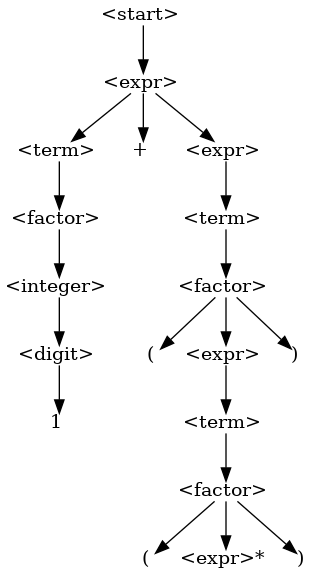

In [53]:
zoom(display_tree(till_abstract(t)))

In [54]:
abs_t_ = find_node(parsed_expr, [0, 2])
tree_to_str(abs_t_), abs_t_[0]

('((2 * 3 / 4))', '<expr>')

In [55]:
abs_t = ('<start>', [abs_t_])

In [56]:
validate_tree(abs_t, EXPR_GRAMMAR)

In [57]:
t_abs_p = [0, 0, 0, 1, 0, 0, 1]
Ts(find_node(abs_t, t_abs_p))

'2 * 3 / 4'

We now define a function to check if a given node is abstract or not.

In [58]:
def e_g_(abstract_a):
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [59]:
def is_node_abstract(node):
    name, children, *abstract_a = node
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [60]:
def tree_to_str_a(tree):
    name, children, *general_ = tree
    if not is_nt(name): return name
    if is_node_abstract(tree):
        return name
    return ''.join([tree_to_str_a(c) for c in children])

In [61]:
Ta = tree_to_str_a

In [62]:
tree_to_str_a(t)

'1 + ((<expr>))'

In [63]:
abs_tree = mark_concrete_r(mark_path_abstract(abs_t, t_abs_p)); abs_tree

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('(', [], {'abstract': False}),
              ('<expr>',
               [('<term>',
                 [('<factor>',
                   [('<integer>',
                     [('<digit>',
                       [('2', [], {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False})],
                   {'abstract': False}),
                  (' * ', [], {'abstract': False}),
                  ('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('3', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' / ', [], {'abstract': False}),
               

In [64]:
Ta(abs_tree)

'((<expr>))'

In [65]:
def mark_abstract_nodes(tree, paths):
    for path in paths:
        tree = mark_path_abstract(tree, t_abs_p)
    return mark_concrete_r(tree)

In [66]:
Ta(mark_abstract_nodes(abs_t, []))

'((2 * 3 / 4))'

In [67]:
Ta(mark_abstract_nodes(abs_t, [t_abs_p]))

'((<expr>))'

### Finding characterizing node

A characterizing node is the lowest node that completely contains the given pattern.

In [68]:
 def find_charecterizing_node(tree):
    name, children, gen = tree
    if len(children) == 1:
        return find_charecterizing_node(children[0])
    return tree

In [69]:
abs_tree_cnode = find_charecterizing_node(abs_tree); abs_tree_cnode

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

As can be seen, the `<factor>` node completely contains the fault pattern.

In [70]:
abs_tree[0], Ts(abs_tree)

('<start>', '((2 * 3 / 4))')

In [71]:
abs_tree_cnode[0], Ts(abs_tree_cnode)

('<factor>', '((2 * 3 / 4))')

### Finding reachable and recursive keys

In [72]:
def find_reachable_keys(grammar, key, reachable_keys=None, found_so_far=None):
    if reachable_keys is None: reachable_keys = {}
    if found_so_far is None: found_so_far = set()

    for rule in grammar[key]:
        for token in rule:
            if not is_nt(token): continue
            if token in found_so_far: continue
            found_so_far.add(token)
            if token in reachable_keys:
                for k in reachable_keys[token]:
                    found_so_far.add(k)
            else:
                keys = find_reachable_keys(grammar, token, reachable_keys, found_so_far)
                # reachable_keys[token] = keys <- found_so_far contains results from earlier
    return found_so_far

In [73]:
reachable = {}
for key in EXPR_GRAMMAR:
    keys = find_reachable_keys(EXPR_GRAMMAR, key, reachable)
    print(key, keys)

<start> {'<term>', '<digit>', '<expr>', '<factor>', '<integer>'}
<expr> {'<term>', '<digit>', '<expr>', '<factor>', '<integer>'}
<term> {'<term>', '<digit>', '<expr>', '<factor>', '<integer>'}
<factor> {'<term>', '<digit>', '<expr>', '<factor>', '<integer>'}
<integer> {'<integer>', '<digit>'}
<digit> set()


Finding recursive keys

In [74]:
def find_recursive_keys(grammar):
    reachable = {}
    found_so_far = {}
    for key in grammar:
        keys = find_reachable_keys(grammar, key, reachable)
        found_so_far[key] = keys
    recursive = []
    for k in found_so_far:
        if k in found_so_far[k]:
            recursive.append(k)
    return recursive

In [75]:
find_recursive_keys(EXPR_GRAMMAR)

['<expr>', '<term>', '<factor>', '<integer>']

In [76]:
def reachable_dict(grammar):
    reachable = {}
    for key in grammar:
        keys = find_reachable_keys(grammar, key, reachable)
        reachable[key] = keys
    return reachable

In [77]:
reachable_dict(EXPR_GRAMMAR)

{'<start>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<expr>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<term>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<factor>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<integer>': {'<digit>', '<integer>'},
 '<digit>': set()}

### Updating the grammar with failure keys

Now, we want to add our grammar the keys that are required to cause a failure. For that, we first extract the local grammar that reproduces the fault pattern 

#### Linear Grammar

In [78]:
abs_tree_cnode

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

In [79]:
 def mark_faulty_name(symbol, prefix, v):
    return '<%s_%s_f%s>'% (symbol[1:-1], prefix, v)

In [80]:
def mark_faulty_nodes(node, prefix, counter=None):
    if counter is None: counter = {}
    symbol, children, *abstract = node
    if is_node_abstract(node): # we dont markup further
        return node
    if symbol not in counter: counter[symbol] = 0
    counter[symbol] += 1
    v = str(counter[symbol])
    if is_nt(symbol):
        return (mark_faulty_name(symbol, prefix, v),
                [mark_faulty_nodes(c, prefix, counter) for c in children],
                *abstract)
    else:
        assert not children
        return (symbol, children, *abstract)

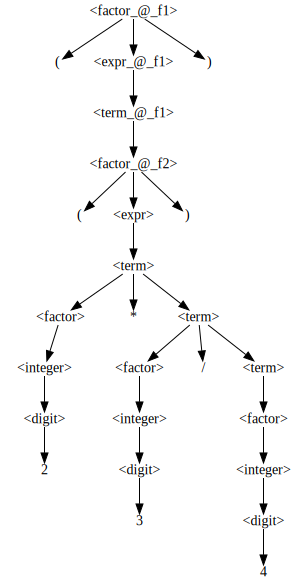

In [81]:
display_tree(mark_faulty_nodes(abs_tree_cnode, '@'))

In [82]:
c_node = mark_faulty_nodes(abs_tree_cnode, '@')

In [83]:
f_node = c_node

In [84]:
def faulty_node_to_grammar(tree, grammar=None):
    if grammar is None: grammar = {}
    if is_node_abstract(tree): return grammar
    name, children, *rest = tree
    tokens = []
    if name not in grammar: grammar[name] = []
    for c in children:
        n, cs, *rest = c
        tokens.append(n)
        if is_nt(n):
            faulty_node_to_grammar(c, grammar)
    grammar[name].append(tuple(tokens))
    return grammar

In [85]:
faulty_node_to_grammar(abs_tree_cnode)

{'<factor>': [('(', '<expr>', ')'), ('(', '<expr>', ')')],
 '<expr>': [('<term>',)],
 '<term>': [('<factor>',)]}

In [86]:
def faulty_node_to_linear_grammar(tree, prefix, grammar=None):
    ltree = mark_faulty_nodes(tree, prefix)
    return faulty_node_to_grammar(ltree)

In [87]:
faulty_node_to_linear_grammar(abs_tree_cnode, '@')

{'<factor_@_f1>': [('(', '<expr_@_f1>', ')')],
 '<expr_@_f1>': [('<term_@_f1>',)],
 '<term_@_f1>': [('<factor_@_f2>',)],
 '<factor_@_f2>': [('(', '<expr>', ')')]}

In [88]:
dd_tree_abs = abs_tree

In [89]:
faulty_node = abs_tree_cnode

### Finding insertable positions

Given a rule, and the faulty symbol, the positions in the rule where the fault can be inserted are all the non-terminals that will eventually reach the symbol of the faulty symbol. That is, if we have `<digit> + <expr>` as the expansion and the faulty symbol is `<factor*>` then, since `<digit>` can never reach `<factor>`, `0` is out, and so is `1` since it is a terminal symbol. Hence, only `<expr>` remains, which when expanded, one of the expansion paths will include a `<factor>`. Hence, here `[2]` is the answer.

In [90]:
def get_insertable_positions(rule, fkey, reachable):
    positions = []
    for i, token in enumerate(rule):
        if not is_nt(token): continue
        if fkey in reachable[token]:
            positions.append(i)
    return positions

In [91]:
reachable = reachable_dict(EXPR_GRAMMAR)

In [92]:
for k in EXPR_GRAMMAR:
    print(k)
    for rule in EXPR_GRAMMAR[k]:
        v = get_insertable_positions(rule, '<factor>', reachable)
        print('\t', rule, v)

<start>
	 ['<expr>'] [0]
<expr>
	 ['<term>', ' + ', '<expr>'] [0, 2]
	 ['<term>', ' - ', '<expr>'] [0, 2]
	 ['<term>'] [0]
<term>
	 ['<factor>', ' * ', '<term>'] [0, 2]
	 ['<factor>', ' / ', '<term>'] [0, 2]
	 ['<factor>'] [0]
<factor>
	 ['+', '<factor>'] [1]
	 ['-', '<factor>'] [1]
	 ['(', '<expr>', ')'] [1]
	 ['<integer>', '.', '<integer>'] []
	 ['<integer>'] []
<integer>
	 ['<digit>', '<integer>'] []
	 ['<digit>'] []
<digit>
	 ['0'] []
	 ['1'] []
	 ['2'] []
	 ['3'] []
	 ['4'] []
	 ['5'] []
	 ['6'] []
	 ['7'] []
	 ['8'] []
	 ['9'] []


### Insert into key definition

 The essential idea is to make the rules in the grammar such that there is one fault position in each position.
Take one rule at a time. For each token in the rule, get the reachable tokens. If the fsym is not in reachable tokens, then the falt can nnot be inserted in that position. So get all positions for the rule that we can insert fsym in, and for each position, change the symbol for later insertion.

In [93]:
def to_faulty_key(name, prefix):
    return "<%s_%s_faulty>" % (name[1:-1], prefix)

In [94]:
def insert_into_key(grammar, key, fsym, prefix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_insertable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # skip this rule because we can not embed the fault here.
            continue
        else:
            # at each position, insert the fsym
            for pos in positions:
                new_rule = copy.deepcopy(rule)
                new_rule[pos] = to_faulty_key(new_rule[pos], prefix)
                my_rules.append(new_rule)
    return (to_faulty_key(key, prefix), my_rules)

In [95]:
for key in EXPR_GRAMMAR:
    fk, rules = insert_into_key(EXPR_GRAMMAR, key, '<factor>', 'xx', reachable)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start_xx_faulty>
     ['<expr_xx_faulty>']

<expr_xx_faulty>
     ['<term_xx_faulty>', ' + ', '<expr>']
     ['<term>', ' + ', '<expr_xx_faulty>']
     ['<term_xx_faulty>', ' - ', '<expr>']
     ['<term>', ' - ', '<expr_xx_faulty>']
     ['<term_xx_faulty>']

<term_xx_faulty>
     ['<factor_xx_faulty>', ' * ', '<term>']
     ['<factor>', ' * ', '<term_xx_faulty>']
     ['<factor_xx_faulty>', ' / ', '<term>']
     ['<factor>', ' / ', '<term_xx_faulty>']
     ['<factor_xx_faulty>']

<factor_xx_faulty>
     ['+', '<factor_xx_faulty>']
     ['-', '<factor_xx_faulty>']
     ['(', '<expr_xx_faulty>', ')']

<integer_xx_faulty>

<digit_xx_faulty>



### Get the final grammar

The final steps are as follows:
1. Add the fault node, and the child nodes to the grammar.
2. Generate the faulty key definitions. This is done per key in the original grammar.
3. Finally, connect the faulty key and fault node.

In [96]:
def remove_duplicate_rules(grammar):
    g = {}
    for k in grammar:
        g[k] = list(set([tuple(rule) for rule in grammar[k]]))
    return g

In [97]:
def get_faulty_grammar(grammar, fault_nodes):
    def to_linear_prefix(i): return '@%d' % i
    def to_faulty_prefix(i): return '%d' % i
    # our new grammar is an updated copy of the old
    new_grammar = copy.deepcopy(grammar)

    # next, update the grammar with the faulty markedup tree.
    for i,f_node in enumerate(fault_nodes):
        # the prefix for ith fault node is [i]
        g = faulty_node_to_linear_grammar(f_node, to_linear_prefix(i))
        new_grammar = {**g, **new_grammar}
    
    reachable = reachable_dict(grammar)
    # the new grammar contains the faulty keys and their definitions.
    for i, fault_node in enumerate(fault_nodes):
        prefix = to_faulty_prefix(i)
        fsym = fault_node[0]
        for key in grammar:
            fk, rules = insert_into_key(grammar, key, fsym, prefix, reachable)
            if rules:
                if fk in new_grammar:
                    new_grammar[fk].extend(rules)
                else:
                    new_grammar[fk] = rules
                    
    new_grammar = remove_duplicate_rules(new_grammar)

    # now, the faulty key is an alternative to the original
    for i, fault_node in enumerate(fault_nodes):
        key = fault_node[0]
        prefix = to_faulty_prefix(i)
        fkey = mark_faulty_name(key, to_linear_prefix(i), 1) # the starting in make_faulty is 1
        fsym = to_faulty_key(key, prefix)
        new_grammar[fsym].append([fkey])
        
    # we now need to stich all start_[i]_faulty together as alternatives
    # to start_faulty.
    new_grammar['<start_faulty>']  = [[to_faulty_key('<start>', to_faulty_prefix(i))]
                                      for i,_ in enumerate(fault_nodes)]
    # and earley parser needs a one rule start
    new_grammar['<start_f>'] = [['<start_faulty>']]
    return new_grammar

In [98]:
faulty_grammar = get_faulty_grammar(EXPR_GRAMMAR, [faulty_node]); faulty_grammar

{'<factor_@0_f1>': [('(', '<expr_@0_f1>', ')')],
 '<expr_@0_f1>': [('<term_@0_f1>',)],
 '<term_@0_f1>': [('<factor_@0_f2>',)],
 '<factor_@0_f2>': [('(', '<expr>', ')')],
 '<start>': [('<expr>',)],
 '<expr>': [('<term>',),
  ('<term>', ' - ', '<expr>'),
  ('<term>', ' + ', '<expr>')],
 '<term>': [('<factor>', ' / ', '<term>'),
  ('<factor>', ' * ', '<term>'),
  ('<factor>',)],
 '<factor>': [('(', '<expr>', ')'),
  ('<integer>', '.', '<integer>'),
  ('<integer>',),
  ('+', '<factor>'),
  ('-', '<factor>')],
 '<integer>': [('<digit>', '<integer>'), ('<digit>',)],
 '<digit>': [('7',),
  ('5',),
  ('8',),
  ('9',),
  ('6',),
  ('4',),
  ('3',),
  ('1',),
  ('2',),
  ('0',)],
 '<start_0_faulty>': [('<expr_0_faulty>',)],
 '<expr_0_faulty>': [('<term>', ' + ', '<expr_0_faulty>'),
  ('<term_0_faulty>', ' + ', '<expr>'),
  ('<term_0_faulty>',),
  ('<term_0_faulty>', ' - ', '<expr>'),
  ('<term>', ' - ', '<expr_0_faulty>')],
 '<term_0_faulty>': [('<factor_0_faulty>', ' * ', '<term>'),
  ('<factor

In [99]:
gf = LimitFuzzer(faulty_grammar)
parser = Parser(faulty_grammar, canonical=True, start_symbol='<start_f>')

In [100]:
for i in range(10):
    s = gf.fuzz(key='<start_f>')
    for t in parser.parse(s):
        print(tree_to_str(t))
    print()

8 + +-+((3)) * (3 * 1 * 5 - 7.6 * 8 - 7) / (6) / --8.3 * (5.6) + -8 / 30.93 * 21.1 / 7.1 * 4.4 * 3 + -+6.0 * -+3 / 9.2 / 5

6 * 0 * (-6.2 * 3.8) + (9 / -5.8 / 8.1 / 1 - (9.1) * 1.6 / 2.4 - 9 / ((1.9)) / 6 + 8 - 8.7) + 3 * -(8 + 1)

53 * ++07.80 / +144 * (5.7 / 1 - 2 - 6) * (9 + 8.4) * 2.2 + +((((6.1)) - 2.7) * 7.7 * 3.8) / 88.27 / -+(0) * (3 - 9.8) / 1.6 / 1.7 / 9 - +(8.3 * 1) - -89.45 * 0 / 4.2

03.3136 / 8 / (-((4)) * 4) / 0.579 + 2 + 2.1 + -(4.1 + 6.8) / -+5 + (4.5 - 2) * 0 * 1.3 * 1 - -5.8 + 4 * 3

((7 / 9 + 8 + 5.4) / 9.53 + (2.0 + 4.1) * 7.0) - ((5.7)) / -(4.2) / ---2.3 / 0.16 * +4.5

+6.579 - -(-((3.3)) / 6 * 9.6 - 2.8 / 0.0) / (-9) / 3.18 * -+9 / 5.0 / 1.8 + (-2 / 6.9 - 0 * 8.8 + 5 - 8.7) - (5) / --8

+-9.7 / +(4 * 6 * 1 - 1.9 * 0 - 2 + 9) / 9.7 * 4.13 / (((7)) / 1.6 - 3) + 0.7 * +++-2 + (5 * 6 * 2 - 5.5 * 2.5 - 2 - 9.6) * +++2 * 3 / -2.2 * 2 + -2 + -(9) * (3) * 5.5 / 8.2 + 3 * 1.0 / 0

+-296 / -7 / 5.96 / -(((2.5)) * 7.8) * +(4) * +9 + +-29.3 / 7787 * +5.0 - ++95.53 - 5.307 + 

In [101]:
for tree in parser.parse('((2))'):
    print(tree)

('<start_f>', [('<start_faulty>', [('<start_0_faulty>', [('<expr_0_faulty>', [('<term_0_faulty>', [('<factor_0_faulty>', [('<factor_@0_f1>', [('(', []), ('<expr_@0_f1>', [('<term_@0_f1>', [('<factor_@0_f2>', [('(', []), ('<expr>', [('<term>', [('<factor>', [('<integer>', [('<digit>', [('2', [])])])])])]), (')', [])])])]), (')', [])])])])])])])])


In [102]:
for tree in parser.parse('((1 + 1))'):
    print(tree)

('<start_f>', [('<start_faulty>', [('<start_0_faulty>', [('<expr_0_faulty>', [('<term_0_faulty>', [('<factor_0_faulty>', [('<factor_@0_f1>', [('(', []), ('<expr_@0_f1>', [('<term_@0_f1>', [('<factor_@0_f2>', [('(', []), ('<expr>', [('<term>', [('<factor>', [('<integer>', [('<digit>', [('1', [])])])])]), (' + ', []), ('<expr>', [('<term>', [('<factor>', [('<integer>', [('<digit>', [('1', [])])])])])])]), (')', [])])])]), (')', [])])])])])])])])


In [103]:
try:
    for tree in parser.parse('1 + 2'):
        print(tree)
except SyntaxError as e:
    print(e)

at '1 + 2'


In [104]:
for tree in parser.parse('1 + ((3))'):
    print(tree)

('<start_f>', [('<start_faulty>', [('<start_0_faulty>', [('<expr_0_faulty>', [('<term>', [('<factor>', [('<integer>', [('<digit>', [('1', [])])])])]), (' + ', []), ('<expr_0_faulty>', [('<term_0_faulty>', [('<factor_0_faulty>', [('<factor_@0_f1>', [('(', []), ('<expr_@0_f1>', [('<term_@0_f1>', [('<factor_@0_f2>', [('(', []), ('<expr>', [('<term>', [('<factor>', [('<integer>', [('<digit>', [('3', [])])])])])]), (')', [])])])]), (')', [])])])])])])])])])
